# CS 541 Final Project - Team 7

Submitted by:
1. John Baldi
2. Shweta Madhale
3. Babafemi Sorinolu
4. Su Zhang

### Imports

In [59]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

In [60]:
#dataset source - https://www.kaggle.com/datasets/dansbecker/nba-shot-logs
df = pd.read_csv("shot_logs.csv")

### Data Cleaning

#### Fixing and dropping features


##### Matchup gives an idea about the date and teams. These are not relevant for a player, so dropping this.

In [61]:
df.MATCHUP

0         MAR 04, 2015 - CHA @ BKN
1         MAR 04, 2015 - CHA @ BKN
2         MAR 04, 2015 - CHA @ BKN
3         MAR 04, 2015 - CHA @ BKN
4         MAR 04, 2015 - CHA @ BKN
                    ...           
128064    OCT 29, 2014 - BKN @ BOS
128065    OCT 29, 2014 - BKN @ BOS
128066    OCT 29, 2014 - BKN @ BOS
128067    OCT 29, 2014 - BKN @ BOS
128068    OCT 29, 2014 - BKN @ BOS
Name: MATCHUP, Length: 128069, dtype: object

In [62]:
df = df.drop(['MATCHUP'], axis = 1)

##### Location, whether the team is home team or an away team, irrelevant so dropping this.

In [63]:
df.LOCATION

0         A
1         A
2         A
3         A
4         A
         ..
128064    A
128065    A
128066    A
128067    A
128068    A
Name: LOCATION, Length: 128069, dtype: object

In [64]:
df = df.drop(['LOCATION'], axis = 1)

##### Gives the same information as the FGM, drop this feature

In [65]:
df = df.drop(['W'], axis = 1)

In [66]:
df = df.drop(['SHOT_NUMBER'], axis = 1)

###### Formatting of time is inappropriate for using, convert this to amount of seconds left in a period

In [67]:
df.GAME_CLOCK

0          1:09
1          0:14
2          0:00
3         11:47
4         10:34
          ...  
128064     1:52
128065    11:28
128066    11:10
128067     2:37
128068     0:12
Name: GAME_CLOCK, Length: 128069, dtype: object

In [68]:
df['SECONDS_LEFT_IN_PERIOD'] = df['GAME_CLOCK'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['LAST_SHOT'] = 0
df.loc[df['SECONDS_LEFT_IN_PERIOD'] <= 1, 'LAST_SHOT'] = 1

In [69]:
df.SECONDS_LEFT_IN_PERIOD

0          69
1          14
2           0
3         707
4         634
         ... 
128064    112
128065    688
128066    670
128067    157
128068     12
Name: SECONDS_LEFT_IN_PERIOD, Length: 128069, dtype: int64

In [70]:
df = df.drop(['GAME_CLOCK'], axis = 1)

##### Fix negative touch time

In [71]:
df = df[df['TOUCH_TIME'] >= 0]

##### Shot result gives same information as the FGM, so drop this feature

In [72]:
df = df.drop(['SHOT_RESULT'], axis = 1)

##### Dropping type of points


In [73]:
df = df.drop(['PTS'], axis = 1)

##### Dropping null values

In [74]:
df.isna().any()

GAME_ID                       False
FINAL_MARGIN                  False
PERIOD                        False
SHOT_CLOCK                     True
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
player_name                   False
player_id                     False
SECONDS_LEFT_IN_PERIOD        False
LAST_SHOT                     False
dtype: bool

In [75]:
df["SHOT_CLOCK"].fillna(df["SHOT_CLOCK"].mean(), inplace=True)

##### Creating shot marker 

In [76]:
df['SHOT_MARKER'] = df['FGM'].replace(['0', '1'], ['0', '^'], inplace=False)

##### Get absolute value of margin

In [77]:
df['ABS_FINAL_MARGIN'] = abs(df['FINAL_MARGIN'])

### Exploring data for extracting more relevant information

Just knowing the closest defender is not a useful feature, so improving on available features. Finding the blocking efficiency of the defender. Also, using the information of efficiency with count of blocked shots, and attempted shots, a ranking for the defenders is obtained. 

In [78]:
defenders = df[['CLOSEST_DEFENDER_PLAYER_ID', 'CLOSEST_DEFENDER']]

In [79]:
df['CLOSEST_DEFENDER_EFFICIENCY'] = [0.0] * len(df)

for defender_id in df['CLOSEST_DEFENDER_PLAYER_ID']:
    temp_df = df[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id]
    temp_eff = (temp_df['FGM'] == 0).sum() / temp_df['FGM'].count()
    df.loc[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id, 'CLOSEST_DEFENDER_EFFICIENCY'] = temp_eff
    
    blockedShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id) & (df['FGM'] == 0)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    allShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKING_EFFICIENCY'] = blockedShots/allShots


C:\Users\madha\AppData\Local\Temp\ipykernel_8860\2737887701.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
C:\Users\madha\AppData\Local\Temp\ipykernel_8860\2737887701.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
C:\Users\madha\AppData\Local\Temp\ipykernel_8860\2737887701.py:12: SettingWithCopyWarn

In [80]:
defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

C:\Users\madha\AppData\Local\Temp\ipykernel_8860\3135344425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)


In [81]:
defenders

,CLOSEST_DEFENDER_PLAYER_ID,CLOSEST_DEFENDER,BLOCKED_SHOTS,ALL_SHOTS,BLOCKING_EFFICIENCY,CLOSEST_DEFENDER_RANK
0,101187,"Anderson, Alan",209.0,382.0,0.547120,135
1,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
2,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
3,203900,"Brown, Markel",27.0,50.0,0.540000,388
4,201152,"Young, Thaddeus",275.0,531.0,0.517891,56
...,...,...,...,...,...,...
128064,203935,"Smart, Marcus",163.0,294.0,0.554422,203
128065,202323,"Turner, Evan",292.0,497.0,0.587525,77
128066,201977,"Thornton, Marcus",71.0,127.0,0.559055,327
128067,202340,"Bradley, Avery",247.0,448.0,0.551339,105


### Aggregating features for each player

##### Get mean of the features for each player

In [82]:
aggFn = {'player_name': 'first', 'player_id' : 'first','PERIOD': 'mean', 'SHOT_CLOCK': 'mean', 'DRIBBLES': 'mean','TOUCH_TIME': 'mean', 'SHOT_DIST': 'mean', 'CLOSE_DEF_DIST': 'mean','CLOSEST_DEFENDER_EFFICIENCY': 'mean', 'LAST_SHOT': 'mean'}
players = df.groupby(df['player_name'], as_index=False).aggregate(aggFn)


##### Get count of shots attempted by a player, count of successful shots, and using these get an approximate shooting efficiency

In [83]:
for player_id in players['player_id']:
    df_temp = df[df['player_id'] == player_id]
    players.loc[(players['player_id'] == player_id), 'ATTEMPTED_SHOTS'] = df_temp['FGM'].count()
    players.loc[(players['player_id'] == player_id), 'BASKETS'] = (df_temp['FGM'] == 1).sum()
    players.loc[(players['player_id'] == player_id), 'SHOOTING_EFFICIENCY'] = ((df_temp['FGM'] == 1).sum())/df_temp['FGM'].count()
    
    df.loc[(df['player_id'] == player_id), 'ATTEMPTED_SHOTS'] = df_temp['FGM'].count()
    df.loc[(df['player_id'] == player_id), 'BASKETS'] = (df_temp['FGM'] == 1).sum()
    df.loc[(df['player_id'] == player_id), 'SHOOTING_EFFICIENCY'] = ((df_temp['FGM'] == 1).sum())/df_temp['FGM'].count()

### Data Visualization

#### Plot the features to understand how they affect the result of a shot

<Axes: xlabel='PERIOD', ylabel='Count'>

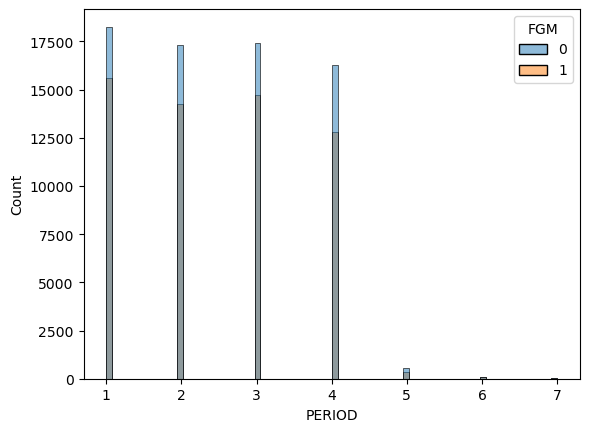

In [84]:
sns.histplot(df, x="PERIOD", hue="FGM", element="bars")

<Axes: xlabel='SHOT_CLOCK', ylabel='Count'>

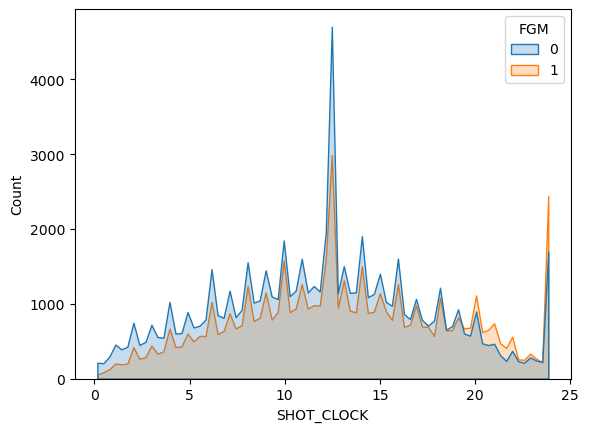

In [85]:
sns.histplot(df, x="SHOT_CLOCK", hue="FGM", element="poly")

<Axes: xlabel='DRIBBLES', ylabel='count'>

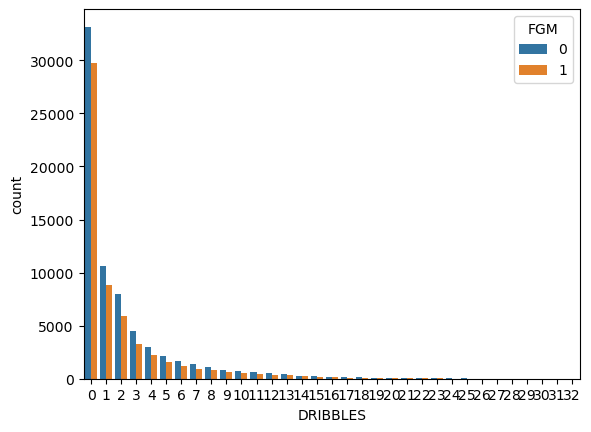

In [86]:
sns.countplot(data=df, x='DRIBBLES', hue='FGM')

<Axes: xlabel='TOUCH_TIME', ylabel='Count'>

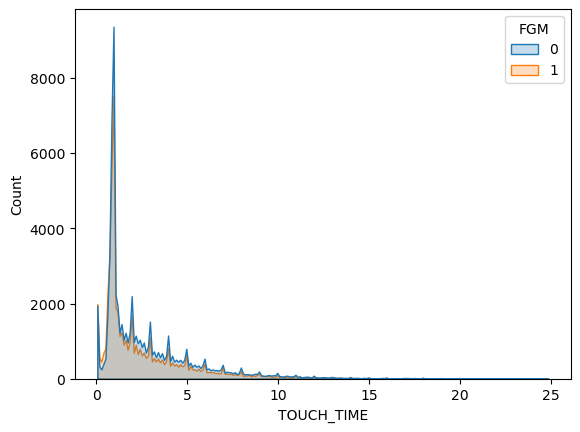

In [87]:
sns.histplot(df, x="TOUCH_TIME", hue="FGM", element="poly")

<Axes: xlabel='SHOT_DIST', ylabel='Count'>

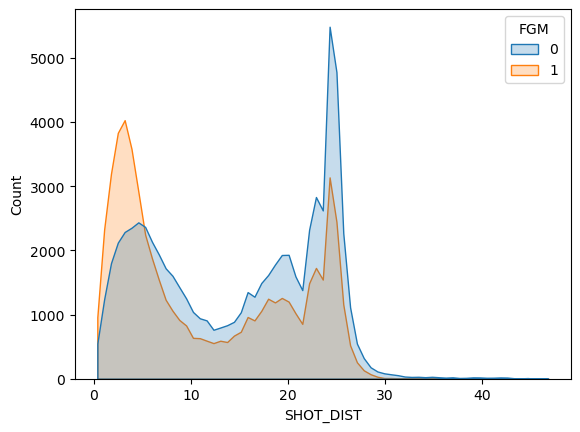

In [88]:
sns.histplot(df, x="SHOT_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSE_DEF_DIST', ylabel='Count'>

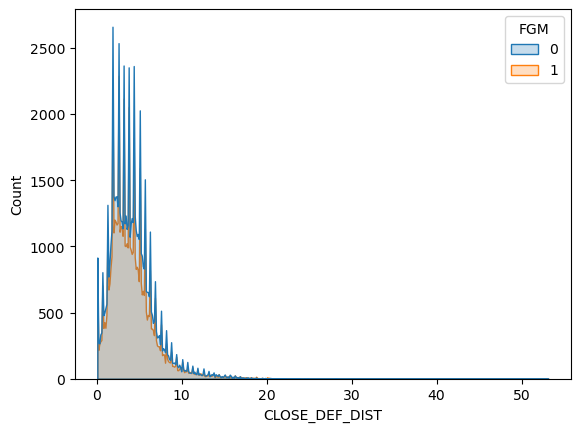

In [89]:
sns.histplot(df, x="CLOSE_DEF_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSEST_DEFENDER_EFFICIENCY', ylabel='Count'>

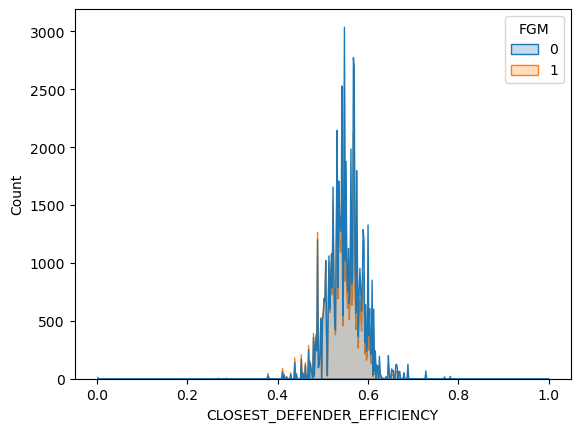

In [90]:
sns.histplot(df, x="CLOSEST_DEFENDER_EFFICIENCY", hue="FGM", element="poly")

<Axes: xlabel='SECONDS_LEFT_IN_PERIOD', ylabel='Count'>

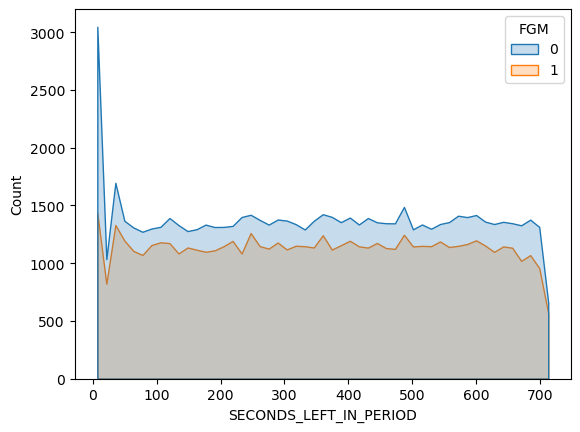

In [91]:
sns.histplot(df, x="SECONDS_LEFT_IN_PERIOD", hue="FGM", element="poly")

#### Find correlation between features

In [92]:
selected_features = df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY','SECONDS_LEFT_IN_PERIOD','FGM']].copy()

<Axes: >

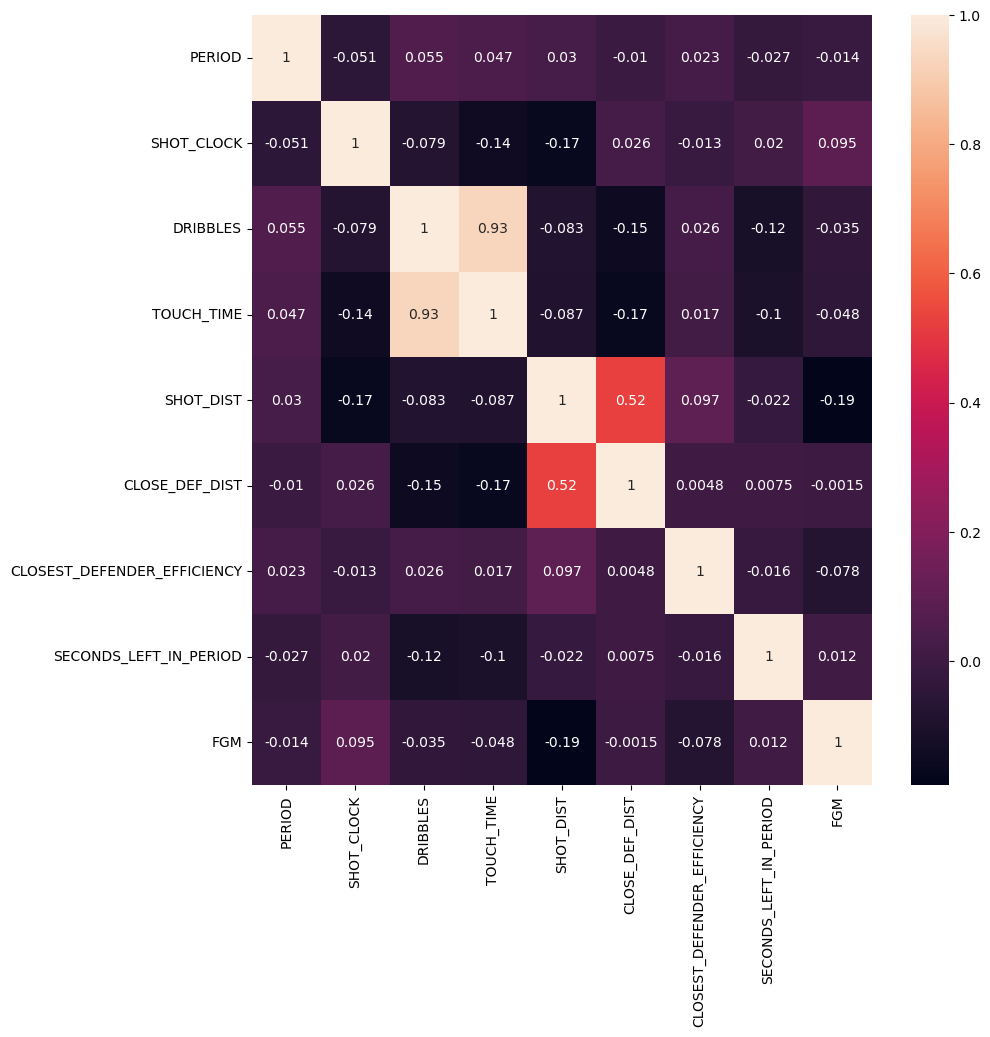

In [93]:
corr = selected_features.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True)

### Clustering Shots by Context

Execution takes long time(Silhouette)!!

In [37]:
selected_ft = df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']]

C:\Users\madha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\madha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\madha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\madha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\madha\anaconda3\lib\site-packages\sklearn\clust

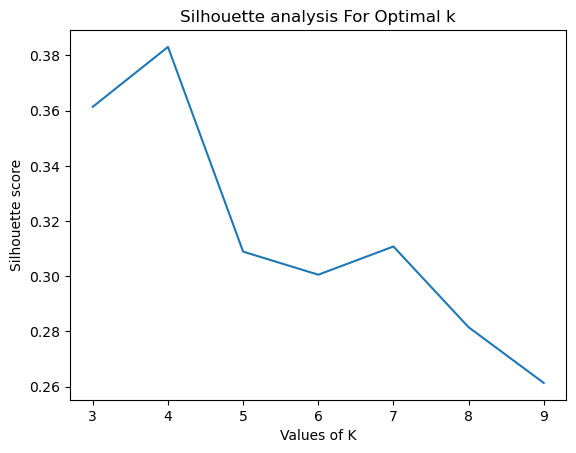

In [38]:
k_max = 10
silhouette_avg = []
for num_clusters in range(3, k_max):
    # initialise kmeans
    kmeans = KMeans(n_clusters = num_clusters).fit(selected_ft)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(selected_ft, cluster_labels, metric = 'euclidean'))

plt.plot(range(3, k_max),silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

C:\Users\madha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


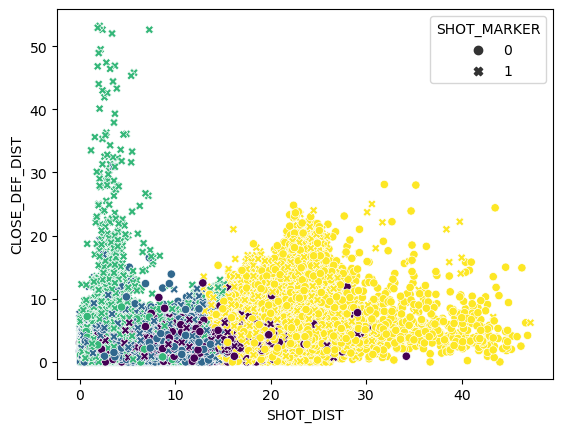

In [94]:
# Clustering

kmeans = KMeans(n_clusters=4)

kmeans.fit(df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']])
# not using SECONDS_LEFT_IN_PERIOD, using LAST_SHOT instead

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [95]:
df['CLUSTER'] = kmeans.labels_
for label in range(0, 4):
    print(label, float(sum(df[df['CLUSTER'] == label]['FGM'])) / float(len(df[df['CLUSTER'] == label]['FGM'])))

0 0.4118243243243243
1 0.4842947368421053
2 0.6005732459067886
3 0.3738123669591402


In [96]:
# Create Cluster average columns

for col in ['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']:
    df['CLUSTER_'+col+'_AVG'] = [0.0] * len(df)
df['CLUSTER_SHOOTING_EFFICIENCY'] = [0.0] * len(df)

for cluster_id in list(df['CLUSTER'].unique()):
    df.loc[df['CLUSTER'] == cluster_id, 'CLUSTER_SHOOTING_EFFICIENCY']  = float(sum(df[df['CLUSTER'] == cluster_id]['FGM'])) / float(len(df[df['CLUSTER'] == cluster_id]['FGM']))
    for col in ['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']:
        temp_avg = df[df['CLUSTER'] == cluster_id][col].mean()
        df.loc[df['CLUSTER'] == cluster_id, 'CLUSTER_'+col+'_AVG'] = temp_avg


In [97]:
df.head()

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,...,CLUSTER,CLUSTER_PERIOD_AVG,CLUSTER_SHOT_CLOCK_AVG,CLUSTER_DRIBBLES_AVG,CLUSTER_TOUCH_TIME_AVG,CLUSTER_SHOT_DIST_AVG,CLUSTER_CLOSE_DEF_DIST_AVG,CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG,CLUSTER_LAST_SHOT_AVG,CLUSTER_SHOOTING_EFFICIENCY
0,21400899,24,1,10.800000,2,1.9,7.7,2,"Anderson, Alan",101187,...,1,2.466274,8.843747,1.685698,2.787601,6.483705,2.604011,0.544522,0.009179,0.484295
1,21400899,24,1,3.400000,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,...,3,2.478411,11.793789,0.930654,1.835948,22.125585,5.681848,0.550442,0.015385,0.373812
2,21400899,24,1,12.450301,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,...,1,2.466274,8.843747,1.685698,2.787601,6.483705,2.604011,0.544522,0.009179,0.484295
3,21400899,24,2,10.300000,2,1.9,17.2,2,"Brown, Markel",203900,...,3,2.478411,11.793789,0.930654,1.835948,22.125585,5.681848,0.550442,0.015385,0.373812
4,21400899,24,2,10.900000,2,2.7,3.7,2,"Young, Thaddeus",201152,...,1,2.466274,8.843747,1.685698,2.787601,6.483705,2.604011,0.544522,0.009179,0.484295


In [98]:
# compare cluster average efficiency to the total average efficiency and reward/penalize for makes/misses

avg_efficiency = sum(df['FGM']) / len(df)

players['Adjusted_Efficiency'] = [0.0] * len(players)
for pid in players['player_id']:
    temp_df = df[df['player_id'] == pid]
    adj_attempts = 0
    adj_makes = 0
    for shot in temp_df.iterrows():
        adj_attempts += 1
        if shot[1]['FGM'] == 0:
            if shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] >= avg_efficiency:
                adj_attempts += 2 * (shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] - avg_efficiency)
            else:
                adj_attempts -= 2 * (avg_efficiency - shot[1]['CLUSTER_SHOOTING_EFFICIENCY'])
        else:
            adj_makes += 1
            if shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] >= avg_efficiency:
                adj_makes -= 2 * (shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] - avg_efficiency)
            else:
                adj_makes += 2 * (avg_efficiency - shot[1]['CLUSTER_SHOOTING_EFFICIENCY'])
    players.loc[players['player_id'] == pid, 'Adjusted_Efficiency'] = adj_makes/adj_attempts


In [99]:
# get adjustment percentage

players['Adjustment'] = players['Adjusted_Efficiency'] - players['SHOOTING_EFFICIENCY']

In [101]:
test = players[players['ATTEMPTED_SHOTS'] > players['ATTEMPTED_SHOTS'].mean()].sort_values(by=['Adjusted_Efficiency', 'Adjustment'], ascending = False)

In [103]:
test_df = test[['player_id']]
test_df["Player_Rank"] = test[['Adjusted_Efficiency']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

C:\Users\madha\AppData\Local\Temp\ipykernel_8860\2347754560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Player_Rank"] = test[['Adjusted_Efficiency']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)


In [104]:
test_df.sort_values(by = 'Player_Rank')

,player_id,Player_Rank
162,2594,1
127,200755,2
3,201143,3
49,101108,4
75,1717,5
...,...,...
245,203524,121
12,203083,122
148,202702,123
192,203487,124


### Empirical Evaluation using Rank Based Overlap and Kendall-Tau Approach

About RBO : https://ai.plainenglish.io/comparing-top-k-rankings-statistically-9adfc9cfc98b

RBO and Kendall Tau : https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899

Dataset from ESPN : https://docs.google.com/spreadsheets/d/1HkOGJh743FG2Y0BRtyaQuUX5vmn2_yKnezbhe8gUz4E/edit?usp=share_link

Source : http://www.espn.com/nba/hollinger/statistics/_/page/1/year/2015

In [ ]:
df2 = pd.read_csv('ESPN_NBA15_Stats - Sheet1.csv')
pn = df2['player_name'].str.split(',', n = 2, expand = True)
df2['player_name'] = pn[0].str.lower()
df2 = df2.iloc[:281]
df2 = df2.sort_values(by = 'player_name')


In [ ]:
df2 = df2.sort_values(by='TS%', ascending=False)
df2 = df2.iloc[:len(test_df)]
df2['new_rank'] = range(1,len(df2)+1)
df2 = df2.sort_values(by = 'player_name')

In [ ]:
S = test_df["Player_Rank"].values.tolist()
#T = df2["Player_Rank"].values.tolist()
T = df2["new_rank"].values.tolist()


In [ ]:
import math
def rbo(list1, list2, p = 0.99):
    def helper(ret, i, d):
        l1 = set(list1[:i]) if i < len(list1) else set(list1)
        l2 = set(list2[:i]) if i < len(list2) else set(list2)
        a_d = len(l1.intersection(l2))/i
        term = math.pow(p, i) * a_d
        if d == i:
            return ret + term
        return helper(ret + term, i + 1, d)
    k = max(len(list1), len(list2))
    x_k = len(set(list1).intersection(set(list2)))
    summation = helper(0, 1, k)
    return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)


In [ ]:
rbo(S, T)*100

58.08479877143403